<a href="https://colab.research.google.com/github/ian-skirkey/Projects/blob/main/Coding1Recent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn

Part 1: Generate Data

(200, 2) (200, 1)
(10000, 2) (10000, 1)


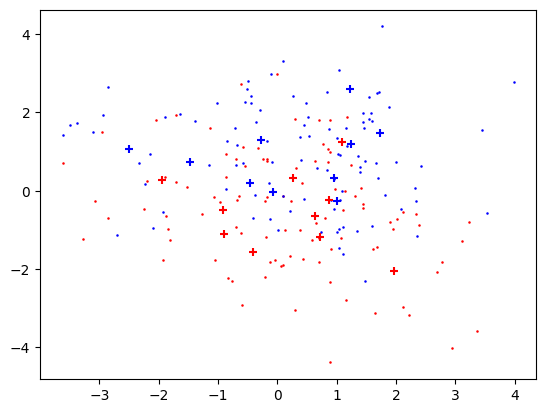

In [ ]:
# Generate Data
np.random.seed(8858)
identity_mat = np.eye(2, 2)

def sample(means, cov_mat):
    return np.random.multivariate_normal(means, identity_mat)

def create_centers(num_centers=20):
    means = np.zeros((2))
    return np.array([sample(means, identity_mat) for _ in range(num_centers)])

def gen_data(centers, num_classes, num_examples):
    examples_per_class = num_examples // num_classes
    num_centers = centers.shape[0]
    centers_per_class = num_centers // num_classes
    X = np.zeros((num_examples, 2))
    Y = np.zeros((num_examples, 1))
    for class_id in range(num_classes):
        for example_id in range(examples_per_class):
            center_idx = np.random.randint(
                class_id * centers_per_class,
                (class_id+1) * centers_per_class,
                size=1
                )
            center = np.squeeze(centers[center_idx])
            point = sample(center, identity_mat)
            point_idx = (class_id * examples_per_class) + example_id
            X[point_idx] = point
            Y[point_idx] = class_id
    return X, Y



centers = create_centers()
# gen_data
train_x, train_y = gen_data(centers, 2, 200)
test_x, test_y = gen_data(centers, 2, 10_000)

plt.scatter(train_x[:100, 0], train_x[:100, 1], s=0.65, c=["red"])
plt.scatter(train_x[100:, 0], train_x[100:, 1], s=0.65, c=["blue"])
plt.scatter(centers[:10, 0], centers[:10, 1], c=["red"], marker="+")
plt.scatter(centers[10:, 0], centers[10:, 1], c=["blue"], marker="+")

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)


Part 2: kNN

Distance ties are handled by taking the element with the smaller index.
Voting ties are handled by marking any voting average at or above 0.5 as class 1.

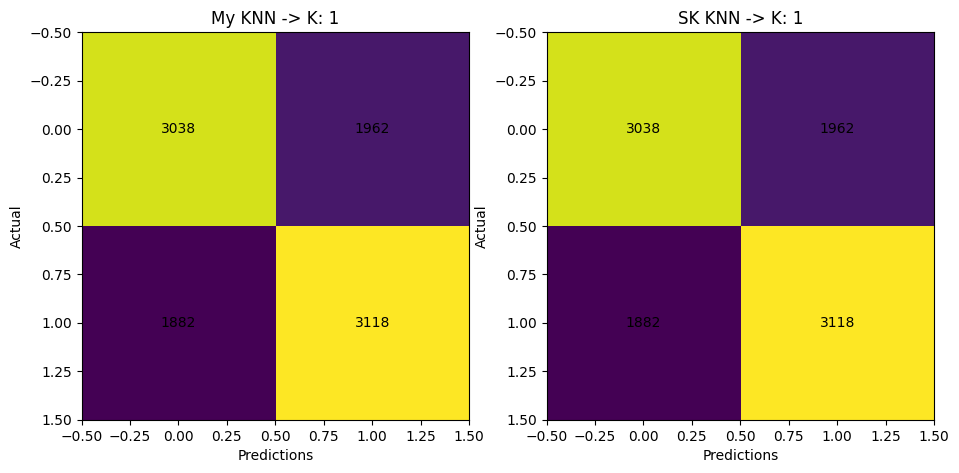

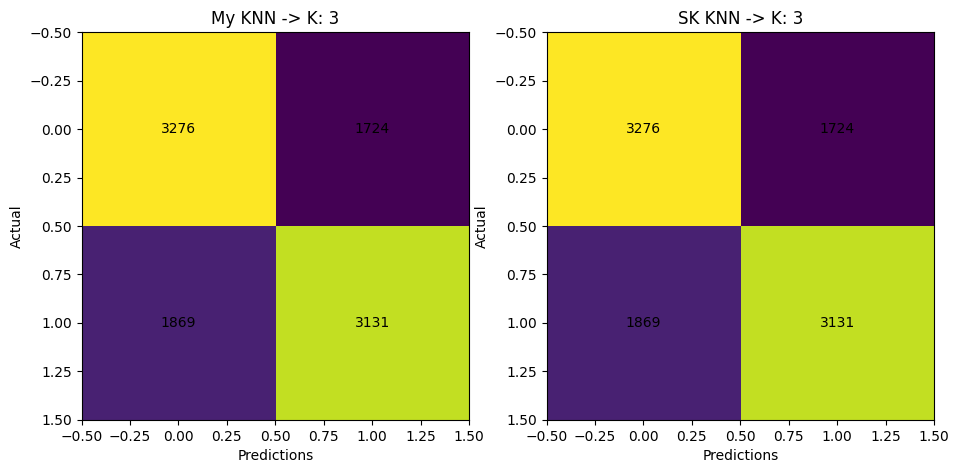

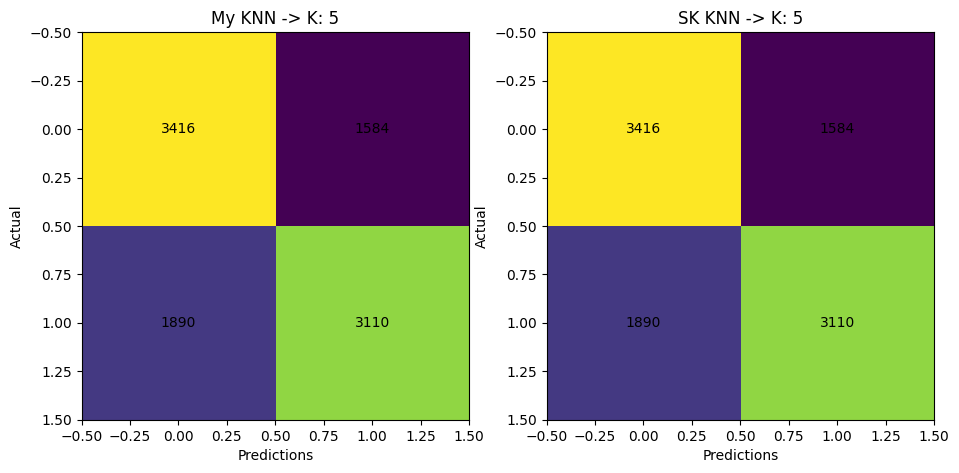

In [ ]:
# kNN

class KNN:
    def __init__(self, X, Y, k):
        assert X.shape[0] == Y.shape[0]
        self.X = X
        self.Y = Y
        self.k = k
        self.num_examples = X.shape[0]

    def get_distances(self, test_x):
        assert test_x.shape[1] == 2
        """
        Euclidian(A, B) = dot(A - B, A - B) = (Ax - Bx)^2 + (Ay - By)^2
        = Ax^2 - 2 * AxBx + Bx^2 + Ay^2 - 2 * AyBy + By^2 = dot(A, A) + dot(B, B) - 2 * dot(A, B)
        """
        A = test_x
        B = self.X
        # np.sum(A**2) is the same as dot(A, A) except instead of being (N, N) its (N, 1)
        # returned shape (number of test points, number of train points)
        return np.sqrt(np.sum(A**2, axis=1, keepdims=True) - 2 * np.dot(A, B.T) + np.sum(B**2, axis=1, keepdims=True).T)

    def predict(self, test_x):
        distances = self.get_distances(test_x)
        dist_idxs = np.argsort(distances)
        # shape: (number of test points, k)
        top_k_idxs = dist_idxs[:, :self.k]
        # shape: (number of test points, k)
        train_pts_labels = np.squeeze(self.Y[top_k_idxs], axis=2)
        # <= 0.5 then it is labeled as class 1
        return np.int32((np.sum(train_pts_labels, axis=1) / self.k) >= 0.5)

def compare_models():
    ks = [1, 3, 5]
    error = np.ones(len(ks))
    predictions = [None for _ in range(len(ks))]
    for i, k in enumerate(ks):
        my_knn = KNN(train_x, train_y, k=k)
        myknn_predictions = my_knn.predict(test_x)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_x, np.squeeze(train_y))
        skknn_predictions = knn.predict(test_x)
        error[i] = np.sum(myknn_predictions - skknn_predictions)
        predictions[i] = (myknn_predictions, skknn_predictions)
    return ks, predictions, error

k_s, predictions, error = compare_models()

def generate_confusion_matrix(y_true, myy_pred, sky_pred, k):
    myconf_matrix = confusion_matrix(y_true=y_true, y_pred=myy_pred)
    skconf_matrix = confusion_matrix(y_true=y_true, y_pred=sky_pred)
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, axes = plt.subplots(1, 2, figsize=(11, 7.5))
    confusion_matrices = [myconf_matrix, skconf_matrix]
    for mat_idx in range(2):
        conf_matrix = confusion_matrices[mat_idx]
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                axes[mat_idx].text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
        title = "My KNN" if mat_idx == 0 else "SK KNN"
        axes[mat_idx].set_title(f"{title} -> K: {k}")
        axes[mat_idx].set_xlabel("Predictions")
        axes[mat_idx].set_ylabel("Actual")
        axes[mat_idx].imshow(conf_matrix)

generate_confusion_matrix(test_y, *predictions[0], k=1)
generate_confusion_matrix(test_y, *predictions[1], k=3)
generate_confusion_matrix(test_y, *predictions[2], k=5)



Part 3: cvKNN

The maximum candidate K value is 180. Why? Because with the number of folds being 10, the size of the training set will be 180, and with a k = 180 class 1 needs 90 examples to win and class 0 needs 91 to win. So with a k > 180, class 1 will always win.

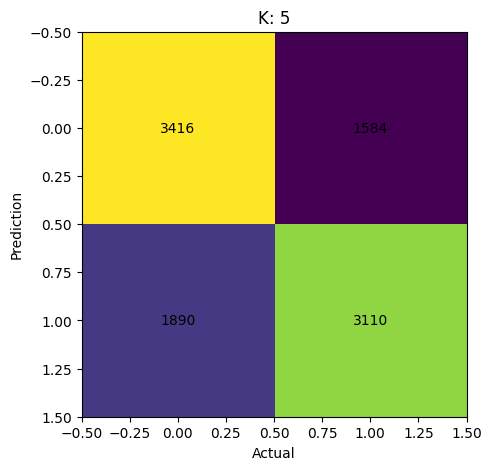

In [ ]:


def fold(nfolds=10):
    candidates = np.array([i for i in range(1, 180 + 1)])
    total_error = np.zeros(len(candidates))
    num_training_examples = train_x.shape[0]
    assert train_x.shape[0] > 180, "Need at least 180 training examples for a k = 180"
    assert num_training_examples % nfolds == 0
    examples_per_fold = num_training_examples // nfolds
    random_indices = np.arange(num_training_examples)
    for i in range(nfolds):
        # with nfold = 10, 90% of training data is used for training
        # and 10% is used for testing
        #
        np.random.shuffle(random_indices)
        train_idxs = np.arange(num_training_examples - examples_per_fold)
        test_idxs = np.arange(num_training_examples - examples_per_fold, num_training_examples)

        X = train_x[train_idxs, :]
        Y = train_y[train_idxs, :]
        TX = train_x[test_idxs, :]
        TY = train_y[test_idxs, :]
        for candidate_idx, k in enumerate(candidates):
            knn_model = KNeighborsClassifier(k)
            knn_model.fit(X, np.squeeze(Y))
            predictions = knn_model.predict(TX)
            total_error[candidate_idx] += sum(predictions != np.squeeze(TY))

    lowest_error = total_error[np.argmin(total_error)]
    equal = candidates[(lowest_error == total_error)]
    best_k = equal[np.argmin(equal / np.arange(1, len(equal) + 1))]
    return best_k, total_error / num_training_examples


best_k, error = fold()
knn_model = KNeighborsClassifier(best_k)
knn_model.fit(train_x, np.squeeze(train_y))
predictions = knn_model.predict(test_x)

fig, ax = plt.subplots(figsize=(5, 5))
conf_matrix = confusion_matrix(y_true=test_y, y_pred=predictions)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
ax.set_title(f"K: {best_k}")
ax.set_xlabel("Actual")
ax.set_ylabel("Prediction")
ax.imshow(conf_matrix)




Part 4: Bayes rule

[1.48206821 1.16658717 0.29192827 ... 3.72617233 0.28212911 2.43194389]
[1 1 0 ... 1 0 1]


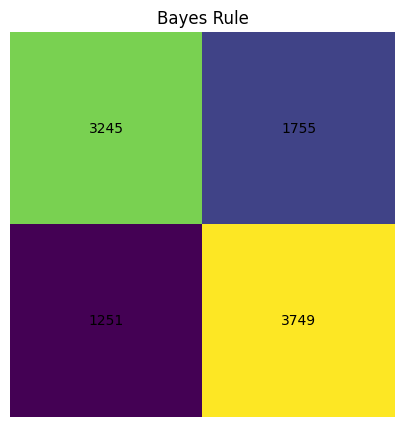

In [ ]:
# define Bayes rule using formula from instructions
# can only loop on num centers 10 or 20
# output 2x2 table like above

# define sigma
s = 1 # TODO, not sure if we need to change this

def bayes_rule():

    # find num
    # (∑ exp(-||x - m1l||^2/(2s^2)))
    # num loop through the class 1 centers
    num = np.zeros(10_000)
    for i in range(10, 20):
        num += np.exp(-np.sum((test_x - centers[i, :])**2, axis=1) / (2 * s**2))

    # find the denom while looping through centers
    # (∑ exp(-||x - m0l||^2/(2s^2)))
    # denom loop through the class 0 centers
    denom = np.zeros(10_000)
    for j in range(10):
        denom += np.exp(-np.sum((test_x - centers[j, :])**2, axis=1) / (2 * s**2))

    return num / denom


# get probability and predictions
result = bayes_rule()
predictions = (result >= 1).astype(int)


# display results
fig, ax = plt.subplots(figsize=(5, 5))
conf_matrix = confusion_matrix(y_true=test_y, y_pred=predictions)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
plt.axis('off')
ax.set_title(f"Bayes Rule")
ax.set_xlabel("Actual")
ax.set_ylabel("Prediction")
ax.imshow(conf_matrix)

Part 5: Simulation Study

In [ ]:
knnerr = []
cvknnerr = []
bayeserr = []
kvalues = []

for i in range(50):
  train_x, train_y = gen_data(centers, 2, 200)
  test_x, test_y = gen_data(centers, 2, 10_000)
  cvk, cverr = fold()
  kvalues.append(cvk)
  knn = KNeighborsClassifier(n_neighbors=7)
  cvknn = KNeighborsClassifier(n_neighbors=cvk)
  bayes_result = bayes_rule()
  bayes_pred = (bayes_result >= 1).astype(int)
  knn.fit(train_x, train_y)
  cvknn.fit(train_x, train_y)
  knn_pred = knn.predict(test_x)
  cvknn_pred = cvknn.predict(test_x)
  test_y = test_y.flatten()
  knnerrs = np.where(test_y != knn_pred, 1, 0)
  cvknnerrs = np.where(test_y != cvknn_pred, 1, 0)
  bayeserrs = np.where(test_y != bayes_pred, 1, 0)
  knnerrsum = np.sum(knnerrs)
  cvknnerrsum = np.sum(cvknnerrs)
  bayeserrsum = np.sum(bayeserrs)
  knnerravg = knnerrsum/len(knnerrs)
  cvknnerravg = cvknnerrsum/len(cvknnerrs)
  bayeserravg = bayeserrsum/len(bayeserrs)
  knnerr.append(knnerravg)
  cvknnerr.append(cvknnerravg)
  bayeserr.append(bayeserravg)



Min K Value:  1
Max K Value:  93
Median K Value:  14.0
25% Quantile K Value:  5.0
75% Quantile K Value:  25.0


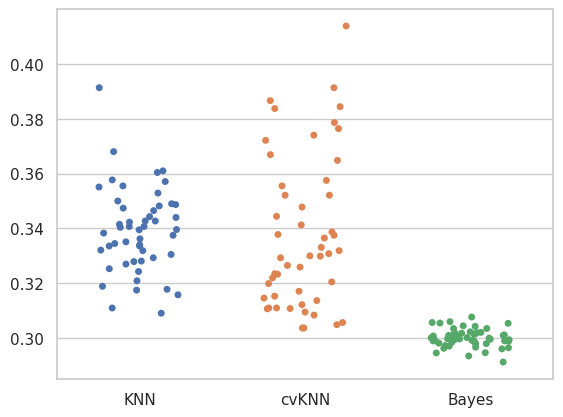

In [ ]:
seaborn.set(style = 'whitegrid')
df = pd.DataFrame.from_dict(data=dict(KNN=knnerr, cvKNN=cvknnerr, Bayes=bayeserr), orient='index').T
seaborn.stripplot(data=df, jitter=0.25)
mink = np.min(kvalues)
maxk = np.max(kvalues)
medk = np.median(kvalues)
quarter = np.quantile(kvalues, 0.25)
threequarter = np.quantile(kvalues, 0.75)
print("Min K Value: ", mink)
print("Max K Value: ", maxk)
print("Median K Value: ", medk)
print("25% Quantile K Value: ", quarter)
print("75% Quantile K Value: ", threequarter)

